<a href="https://colab.research.google.com/github/olvad/DeepLearning_course/blob/main/Object_detection_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-11 14:52:58--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-11 14:52:58--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip.6’

data.zip.6          100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2023-12-11 14:52:59 (270 MB/s) - ‘data.zip.6’ saved [38392108/38392108]

replace data/class_dict? [y]es, [n]o, [

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        class_name = member.find("name").text
        class_id = class_dict[class_name]
        res = (xmin, ymin, xmax, ymax, class_id)
        bboxes.append(res)
    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))


        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert('RGB'))
        bboxes = get_xml_data(fname, self.root, self.class_dict)
        transformed = self.transform(image=image, bboxes=bboxes)
        return transformed

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###

        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

In [ ]:
out = [train_ds[i] for i in range(6)]
out

[{'image': tensor([[[-0.9020, -0.8849, -0.8507,  ..., -0.1828, -0.3883, -0.4739],
           [-0.7479, -0.7650, -0.7479,  ..., -0.4226, -0.3198, -0.0458],
           [-0.7137, -0.6794, -0.6452,  ..., -0.0972,  0.1768,  0.4679],
           ...,
           [-1.3473, -1.2959, -1.2788,  ..., -0.3198, -0.3198, -0.3198],
           [-1.2617, -1.2617, -1.2788,  ..., -0.2171, -0.1657, -0.1486],
           [-1.2617, -1.2959, -1.3644,  ..., -0.1143, -0.0801, -0.0629]],
  
          [[-1.1604, -1.1604, -1.1078,  ..., -0.5476, -0.7402, -0.8277],
           [-1.0028, -1.0203, -1.0028,  ..., -0.7752, -0.6702, -0.3901],
           [-0.9678, -0.9328, -0.8978,  ..., -0.4776, -0.1975,  0.1001],
           ...,
           [-1.5805, -1.5280, -1.4930,  ..., -0.5301, -0.5301, -0.5301],
           [-1.4930, -1.4930, -1.5105,  ..., -0.4076, -0.3725, -0.3550],
           [-1.4930, -1.5280, -1.5805,  ..., -0.3200, -0.2850, -0.2675]],
  
          [[-1.2990, -1.2990, -1.2293,  ..., -0.8458, -1.0376, -1.1247],
  

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
import matplotlib.patches as patches

In [ ]:
def visualize(images, bboxes, class_dict_inv):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        img = images[i].permute(1, 2, 0).numpy()
        img = std * img + mean

        ax.imshow(img)

        for bbox in bboxes[i]:
          xmin, ymin, xmax, ymax, class_id = bbox
          rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
          ax.add_patch(rect)
          ax.text(xmin, ymin, class_dict_inv[class_id], bbox=dict(facecolor='yellow', alpha=0.5))

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

In [ ]:
out = [train_ds[i] for i in range(6)]

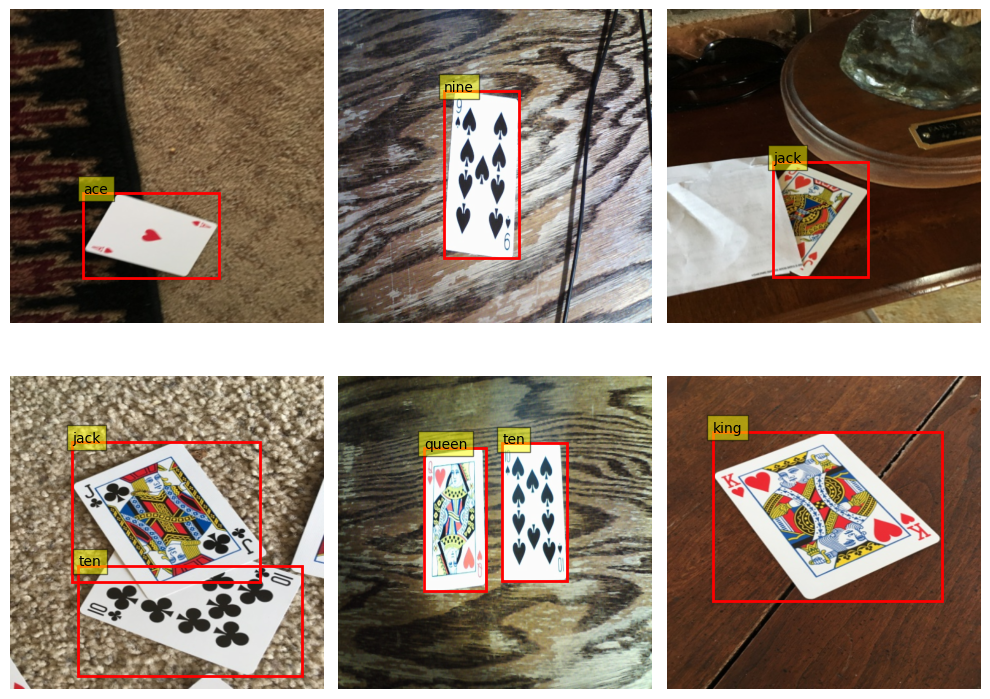

In [ ]:
visualize([o["image"] for o in out], [o["bboxes"] for o in out], train_ds.class_dict_inv)

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  downsample
        y_cell =  downsample
        w_box =  (xmax - xmin) / 512

        h_box =  (ymax - ymin) / 512

        # Посчитайте координаты центра и сдвиги
        cx =  (xmin + xmax) / 2
        cy =  (ymin + ymax) / 2
        cx_idx =  cx // x_cell  # (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx =  cy // y_cell

        cy_idx = cy_idx.to(torch.long)
        cx_idx = cx_idx.to(torch.long)

        cx_box = (cx - cx_idx * x_cell) / x_cell
        cy_box = (cy - cy_idx * y_cell) / y_cell




        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

In [ ]:
train_ds

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

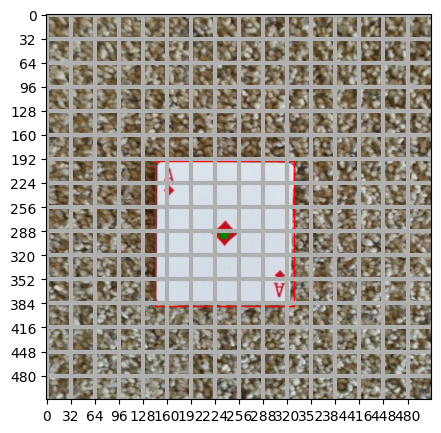

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    decoded = []
    for batchh in range(b):
      bboxes = []
      for y in range(h):
        for x in range(w):
          if pred[batchh, 4, y, x] >= threshold:
            cx_box = pred[batchh, 0, y, x]
            cy_box = pred[batchh, 1, y, x]
            w_box = pred[batchh, 2, y, x]
            h_box = pred[batchh, 3, y, x]
            cx = (x + cx_box) * upsample
            cy = (y + cy_box) * upsample
            width = w_box * img_w
            height = h_box * img_h
            xmin = cx - width / 2
            ymin = cy - height / 2
            xmax = cx + width / 2
            ymax = cy + height / 2

            if c > 6:
              class_id = torch.argmax(pred[batchh, 5:, y, x]).item()
            else:
              class_id = pred[batchh, 5, y, x].item()

            bboxes.append([xmin, ymin, xmax, ymax, class_id])
      decoded.append(bboxes)
    return decoded


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
C =  6


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.base_layers = nn.Sequential(*list(model.children())[:-2])
        for param in self.base_layers.parameters():
            param.requires_grad = False #так лучше учится
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.base_layers(img)
        x = self.conv_layers(x)
        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
def special_loss(pred, target, check=False, C=C):
    detect_cf = 1
    nondetect_cf = 0.1


    mask = target[:, 4, :, :] == 1

    locloss_cx = torch.nn.functional.mse_loss(torch.masked_select(pred[:, 0, :, :], mask), torch.masked_select(target[:, 0, :, :], mask), reduction='sum')
    locloss_cy = torch.nn.functional.mse_loss(torch.masked_select(pred[:, 1, :, :], mask), torch.masked_select(target[:, 1, :, :], mask), reduction='sum')

    localization_loss = locloss_cx + locloss_cy


    boxl_h = torch.nn.functional.mse_loss(torch.masked_select(pred[:, 2, :, :], mask), torch.masked_select(target[:, 2, :, :], mask), reduction='sum')
    boxl_w = torch.nn.functional.mse_loss(torch.masked_select(pred[:, 3, :, :], mask), torch.masked_select(target[:, 3, :, :], mask), reduction='sum')

    box_loss = boxl_h + boxl_w

    array = []
    for i in range(C):
      array.append(torch.masked_select(pred[:, 5 + i, :, :], mask))
    class_preds = torch.stack(array, dim=1)
    class_targets = torch.masked_select(target[:, 5, :, :].long(), mask)
    classification_loss = torch.nn.functional.cross_entropy(class_preds, class_targets, reduction='sum')

    confidence_loss_det = torch.nn.functional.binary_cross_entropy(torch.masked_select(pred[:, 4, :, :], mask), torch.masked_select(target[:, 4, :, :], mask), reduction='sum')
    confidence_loss_nondet = torch.nn.functional.binary_cross_entropy(torch.masked_select(pred[:, 4, :, :], ~mask), torch.masked_select(target[:, 4, :, :], ~mask), reduction='sum')
    confidence_loss = confidence_loss_det * detect_cf  + confidence_loss_nondet * nondetect_cf

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

In [ ]:
special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3)

(tensor(5120.), tensor(5120.), tensor(2812.4465), tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(21)
EPOCHS =  15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images = batch["image"].to(device)
        targets = batch["target"].to(device)

        opt.zero_grad()
        predictions = model(images)
        loss = special_loss(predictions, targets)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 101.591;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 42.386;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 31.170;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 27.324;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 25.532;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 24.283;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 22.870;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 21.825;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 21.042;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 20.391;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 20.020;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 19.879;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 19.979;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 20.142;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 19.727;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu
with torch.no_grad():
    preds = model(batch['image'].to(device)).cpu()

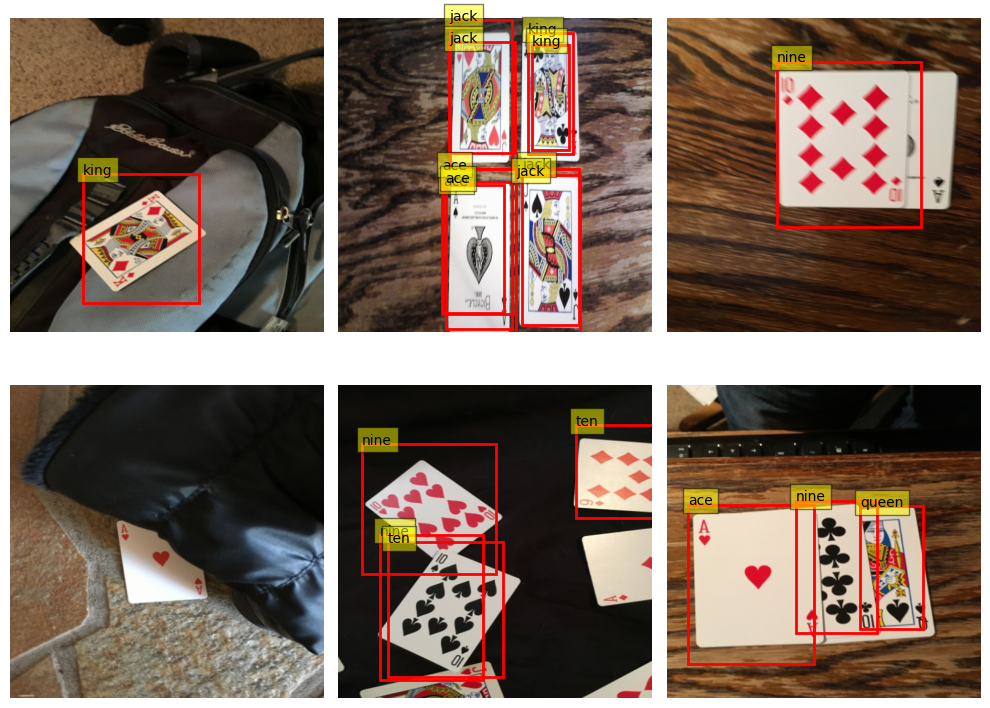

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
visualize(batch['image'], decode_prediction(preds, upsample=32, threshold = 0.2),class_dict_inv = train_ds.class_dict_inv )

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.4/660.4 kB 13.0 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    yolo_annotations = []

    for bbox in bboxes:
        x_min, y_min, x_max, y_max, class_id = bbox

        # Переводим координаты в относительные
        center_x = (x_min + x_max) / (2 * w_im)
        center_y = (y_min + y_max) / (2 * h_im)
        width = (x_max - x_min) / w_im
        height = (y_max - y_min) / h_im

        # Форматируем строку в соответствии с требованиями YOLO
        yolo_format = f"{class_id} {center_x} {center_y} {width} {height}"
        yolo_annotations.append(yolo_format)

    return yolo_annotations

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

In [ ]:
h_im, w_im, ch = np.array(Image.open(result[0])).shape
print(h_im, w_im, ch)

504 378 3


In [ ]:
result[1]

[(29, 262, 108, 459, 4), (99, 249, 238, 425, 3)]

In [ ]:
annotation2txt(result[1], 512, 512) # тут я просто изучал норм ли работает

['4 0.1337890625 0.7041015625 0.154296875 0.384765625',
 '3 0.3291015625 0.658203125 0.271484375 0.34375']

In [ ]:
# Собираем YAML

class_dict = {"king": 0, "jack": 1, "ace": 2, "ten": 3, "nine": 4, "queen": 5}

nc =  len(class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
import ultralytics

model = ultralytics.YOLO('yolov8n.yaml')
model.train(data="data.yaml", epochs=100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 19.7MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 84.7MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 582.80it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 600.65it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.4G      3.021      4.673      4.407         21        640: 100%|██████████| 21/21 [00:11<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


                   all         37         68   0.000313     0.0732   0.000233   5.47e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.71G      2.951      4.348      4.097         18        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         37         68    0.00025     0.0524   0.000164   5.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.71G      2.886      3.943       3.84         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         37         68   0.000339     0.0499   0.000203   3.54e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.71G      2.849      3.675      3.601         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


                   all         37         68   0.000262     0.0524   0.000187   3.62e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.73G      2.777      3.551      3.408         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         37         68      0.768     0.0434     0.0527     0.0211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.7G      2.725      3.427      3.258         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         37         68      0.562     0.0896     0.0506     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.71G      2.631      3.192      3.115         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


                   all         37         68      0.131      0.187      0.119     0.0537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.71G      2.437      3.069      2.989         24        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         37         68      0.265      0.137      0.116     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.73G      2.256      2.885      2.873         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         37         68      0.469      0.219      0.246      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.72G       2.16      2.756      2.753         24        640: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         37         68      0.238       0.22      0.264      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.69G      2.003      2.638      2.631         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         37         68      0.198      0.404      0.293      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.71G      1.937      2.611      2.553         18        640: 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         37         68      0.489      0.654      0.516       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.73G      1.809      2.482       2.37         22        640: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         37         68      0.292      0.762      0.455      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.73G      1.816      2.465      2.378         15        640: 100%|██████████| 21/21 [00:06<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         37         68      0.407      0.626       0.44      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.72G      1.685      2.359      2.268         23        640: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         37         68      0.395      0.594      0.456      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.72G       1.61      2.325      2.201         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         37         68      0.392      0.566      0.507      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.71G      1.573      2.204      2.145         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


                   all         37         68      0.374      0.596      0.465      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.72G       1.47      2.161      2.046         21        640: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         37         68      0.492      0.633      0.578      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.74G       1.42      2.137      1.992         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


                   all         37         68      0.432      0.696       0.54      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.74G      1.333      2.024      1.909         17        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


                   all         37         68      0.484      0.751      0.567      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.71G      1.346       2.03      1.936         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


                   all         37         68      0.448      0.673      0.482      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.73G      1.306      1.946      1.855         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


                   all         37         68       0.41      0.752      0.573      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.71G      1.308       1.92      1.836         29        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         37         68      0.416      0.711      0.502      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.72G      1.283      1.955      1.836         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         37         68      0.529      0.681      0.604      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.71G      1.234      1.865      1.786         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         37         68      0.422      0.822      0.588      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.73G      1.196      1.782      1.756         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         37         68      0.508      0.715       0.57      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.71G        1.2      1.807      1.739         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         37         68      0.491      0.686       0.65      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.69G      1.182      1.767      1.713         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         37         68       0.51      0.715      0.605      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.71G      1.174       1.75      1.698         14        640: 100%|██████████| 21/21 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         37         68      0.523      0.868      0.694      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.71G      1.131      1.684      1.659         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         37         68      0.545      0.681      0.663      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.72G      1.086      1.662      1.623         26        640: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


                   all         37         68      0.459      0.847      0.635      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.72G      1.133      1.677      1.645         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


                   all         37         68      0.579      0.837      0.711       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.69G      1.084      1.615      1.606         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


                   all         37         68      0.542      0.733      0.708      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.71G      1.075       1.62      1.598         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         37         68      0.543      0.842      0.715        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.72G       1.04      1.573      1.554         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         37         68      0.511       0.84      0.666      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.71G      1.049      1.566       1.55         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


                   all         37         68      0.492       0.85      0.702      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.69G      1.012      1.511      1.524         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         37         68      0.494      0.812      0.721      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.72G       1.01      1.498      1.506         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         37         68      0.563      0.845      0.738      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.71G     0.9815      1.504      1.494         33        640: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         37         68      0.656      0.754      0.747      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.71G     0.9879      1.492      1.497         39        640: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         37         68      0.849      0.699      0.814      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.71G     0.9561      1.456      1.477         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


                   all         37         68      0.627      0.839      0.771      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.71G      0.934      1.432      1.456         38        640: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         37         68      0.592       0.81      0.729      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.72G     0.9427      1.426      1.473         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         37         68      0.642      0.782      0.743       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.73G      0.911      1.398      1.426         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         37         68      0.526      0.816      0.775      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.71G     0.9117      1.382      1.442         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         37         68      0.614      0.827      0.731      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.71G     0.9086      1.395      1.439         27        640: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         37         68      0.693      0.853      0.797      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.73G     0.9284      1.378      1.436         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         37         68      0.641      0.923      0.807      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.72G     0.9096      1.341      1.416         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


                   all         37         68       0.57      0.814      0.774      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.69G      0.872       1.31      1.401         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


                   all         37         68      0.689      0.854      0.832      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.72G     0.8938      1.304       1.42         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         37         68      0.604      0.739      0.784      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.71G     0.8971      1.311       1.42         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         37         68       0.65      0.879       0.86      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.71G     0.8922      1.255        1.4         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         37         68      0.838      0.692      0.837      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.71G     0.8703       1.31      1.381         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         37         68      0.576      0.855      0.806      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.74G     0.8704      1.284      1.405         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         37         68      0.712      0.819       0.85      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.71G     0.8286      1.222      1.362         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         37         68      0.645      0.729      0.754       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.73G      0.841      1.268      1.371         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         37         68      0.552      0.849      0.772      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.71G     0.8058      1.218      1.341         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


                   all         37         68       0.77      0.924      0.922      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.71G     0.8302      1.199      1.357         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         37         68      0.588       0.94      0.798      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.72G     0.8431      1.222      1.354         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


                   all         37         68      0.541      0.883      0.759      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.69G     0.8067      1.181       1.32         17        640: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         37         68      0.697      0.943      0.844      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.69G     0.7955      1.172      1.334         32        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


                   all         37         68      0.822      0.769      0.893      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.73G      0.803      1.134      1.336         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


                   all         37         68      0.819      0.787      0.887      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.71G     0.8094      1.195       1.35         25        640: 100%|██████████| 21/21 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         37         68      0.715      0.874      0.884      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.72G     0.7902      1.132      1.313         18        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


                   all         37         68      0.739      0.745      0.827      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.73G     0.8171      1.175      1.345         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         37         68       0.87      0.819      0.912      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.7G     0.7802       1.11      1.302         38        640: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         37         68      0.848      0.825      0.895      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.71G     0.8094      1.151      1.346         12        640: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


                   all         37         68      0.829      0.833      0.878      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.73G     0.7721      1.052      1.297         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


                   all         37         68      0.903      0.825      0.904      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.71G     0.7667      1.065      1.286         19        640: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         37         68      0.897      0.813      0.914      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.71G     0.7581      1.054      1.289         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         37         68      0.811      0.913      0.923       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.71G     0.7714      1.068      1.285         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         37         68      0.787       0.79      0.891      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.72G     0.7651      1.041      1.297         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


                   all         37         68      0.862      0.834       0.92      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.73G     0.7682      1.069      1.303         16        640: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         37         68      0.877      0.899      0.946      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.7G     0.7539      1.037      1.283         16        640: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         68      0.911      0.799       0.93       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.74G     0.7479      1.037      1.278         16        640: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         37         68      0.889      0.925      0.968      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.73G     0.7503      1.019      1.288         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         37         68      0.897      0.848      0.907      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.71G     0.7264      1.016      1.265         21        640: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         37         68      0.868      0.872       0.92      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.71G     0.7314     0.9967      1.268         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         37         68      0.838      0.889      0.915      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.72G     0.7298      1.021      1.284         22        640: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         37         68      0.907       0.82      0.901      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.71G     0.7196      1.001      1.259         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         37         68      0.915      0.841       0.94      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.71G      0.719     0.9787      1.266         19        640: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         37         68      0.864      0.792      0.889      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.71G     0.7202     0.9794      1.258         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         37         68      0.854      0.903      0.964      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.71G     0.7087     0.9796      1.242         16        640: 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         37         68      0.891      0.864      0.945      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.71G     0.7163     0.9691      1.261         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         37         68      0.954      0.834      0.957      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.71G     0.7199     0.9789      1.264         28        640: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         37         68      0.854      0.884      0.944      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.72G     0.6832     0.9269      1.224         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         68      0.945      0.877      0.969      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.73G     0.6803      0.934      1.223         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         37         68      0.915      0.818      0.929      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.72G     0.6793     0.9296      1.217         13        640: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         37         68      0.936      0.847      0.961      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.73G     0.6796     0.9081      1.224         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         37         68      0.927       0.92      0.973      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.69G     0.7194     0.9481      1.267         28        640: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         37         68      0.925      0.925      0.977      0.878


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.83G     0.5585     0.8078      1.098         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


                   all         37         68       0.93      0.865      0.939      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.7G     0.5382     0.8063        1.1         11        640: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         37         68      0.952      0.916      0.975      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.69G     0.5145      0.707      1.079         12        640: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         37         68      0.943      0.833      0.942      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.7G     0.5175     0.7312      1.064         11        640: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         37         68      0.912      0.921       0.97      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.69G     0.4943      0.708      1.047         10        640: 100%|██████████| 21/21 [00:05<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         37         68      0.928      0.891      0.951      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.7G     0.4945     0.7234      1.067         14        640: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         37         68      0.872      0.864      0.936      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.69G     0.5053     0.6944      1.061         14        640: 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         37         68        0.9      0.911      0.959      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.69G     0.4892     0.6712      1.047         10        640: 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         37         68      0.929      0.878      0.946      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.69G     0.4947     0.6799      1.057          8        640: 100%|██████████| 21/21 [00:05<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         37         68      0.924      0.867      0.958      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.69G     0.5058     0.6823       1.06          8        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         37         68      0.955      0.917      0.973      0.881



100 epochs completed in 0.216 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


                   all         37         68      0.954      0.917      0.973      0.881
                  king         37         12      0.921       0.97      0.983       0.95
                  jack         37          8      0.951      0.875      0.939      0.775
                   ace         37         16      0.888          1      0.988      0.919
                   ten         37         11      0.966      0.909      0.981       0.85
                  nine         37         13          1      0.897      0.995      0.931
                 queen         37          8          1      0.852      0.955      0.861
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a2c2c690790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
iteration = 2 # это нужно для нахождения папок. Как я понял, по каждой итерации создается новая папка. Ниже в коде это есть


image 1/1 /content/valid/images/cam_image38.jpg: 384x640 1 king, 2 jacks, 1 ace, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train2


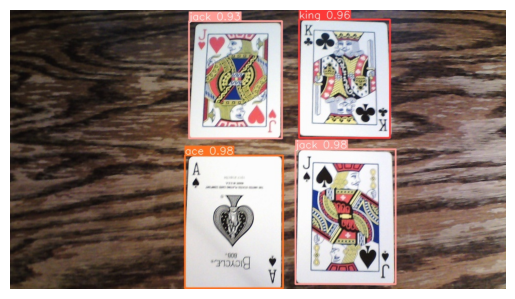


image 1/1 /content/valid/images/IMG_2474.JPG: 640x480 1 ace, 18.4ms
Speed: 2.8ms preprocess, 18.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train3


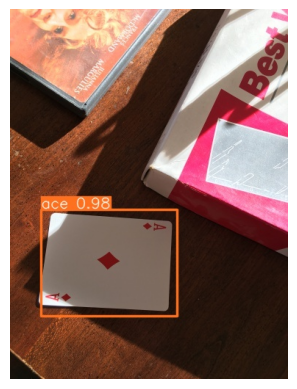


image 1/1 /content/valid/images/IMG_2526.JPG: 640x480 1 king, 1 queen, 18.5ms
Speed: 2.6ms preprocess, 18.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train4


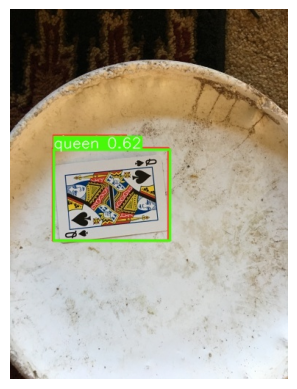


image 1/1 /content/valid/images/cam_image6.jpg: 384x640 4 nines, 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train5


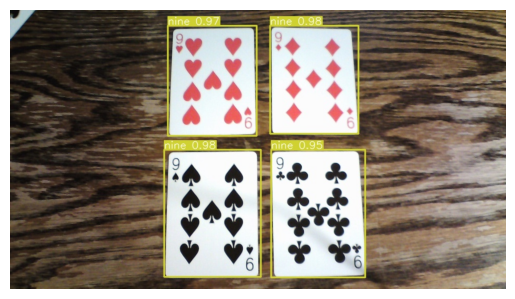


image 1/1 /content/valid/images/IMG_2587.JPG: 640x480 1 king, 2 aces, 1 nine, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train6


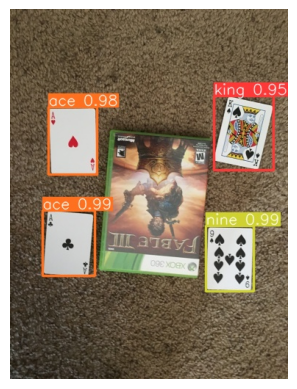


image 1/1 /content/valid/images/cam_image12.jpg: 384x640 1 king, 11.6ms
Speed: 2.7ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train7


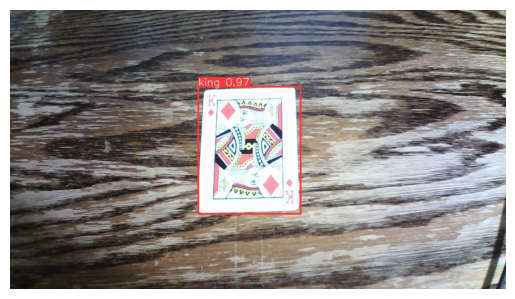


image 1/1 /content/valid/images/cam_image23.jpg: 384x640 1 queen, 12.8ms
Speed: 2.7ms preprocess, 12.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train8


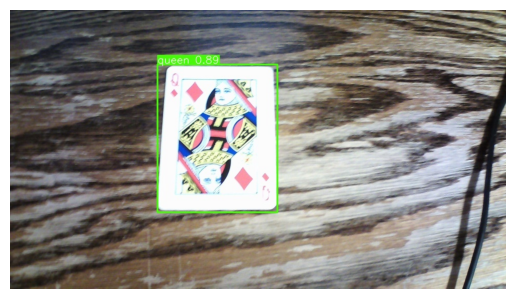


image 1/1 /content/valid/images/IMG_2558.JPG: 640x480 1 king, 1 ace, 2 tens, 1 queen, 11.4ms
Speed: 3.6ms preprocess, 11.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train9


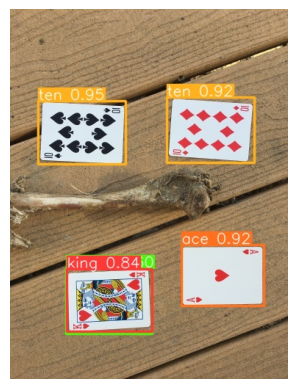


image 1/1 /content/valid/images/IMG_2482.JPG: 640x480 1 queen, 15.1ms
Speed: 5.8ms preprocess, 15.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train10


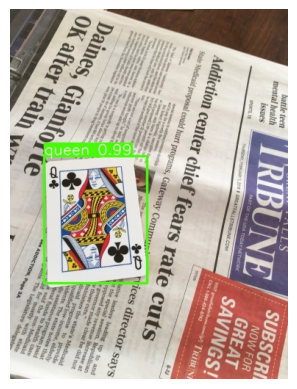


image 1/1 /content/valid/images/cam_image37.jpg: 384x640 2 kings, 2 aces, 11.5ms
Speed: 3.1ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train11


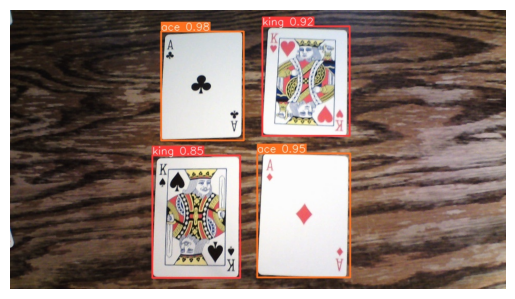


image 1/1 /content/valid/images/cam_image21.jpg: 384x640 1 queen, 12.4ms
Speed: 2.8ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/train12


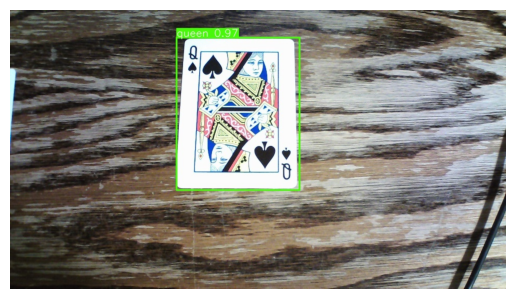


image 1/1 /content/valid/images/IMG_2565.JPG: 640x480 1 king, 1 ten, 1 nine, 1 queen, 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train13


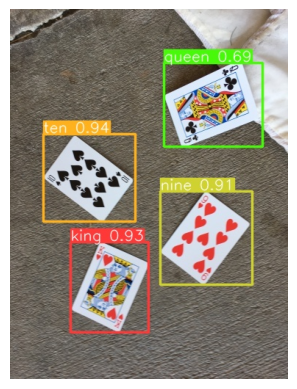

In [ ]:
import os


image_dir = '/content/valid/images'
image_files = os.listdir(image_dir)
selected_images = image_files[4:16]

for image_file in selected_images:
    image_path = os.path.join(image_dir, image_file)
    model.predict(image_path, save = True)
    ValPath = '/content/runs/detect/train' + str(iteration)
    iteration += 1
    name = image_path.split('/')[-1]
    printpath = ValPath + '/' + name
    image = Image.open(printpath)
    plt.imshow(image)
    plt.axis('off')
    plt.show()



